In [14]:
import instaloader
from emoji import UNICODE_EMOJI

import os
import re
import json
import shutil

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

download_dir = os.path.join("data",'raw')
os.makedirs(download_dir, exist_ok=True)

failed_posts = []

loader = instaloader.Instaloader()
# loader.load_session_from_file('rafadimare')

In [2]:
import re
import string
from bs4 import BeautifulSoup
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import emoji
import contractions
from autocorrect import Speller
from unidecode import unidecode

from scipy.sparse import csr_matrix

In [3]:
import scipy.sparse as sps

import louvain
import igraph as ig

<ipython-input-3-a6e011f3cea3>:3: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


# Data retrieval

## Post downloading

In [4]:
xl_path = os.path.join('data','resources','database.xlsx')

already_downloaded = os.listdir(download_dir)

with pd.ExcelFile(xl_path) as xl:
    df = xl.parse() \
           .drop(columns=['id']) \
           .dropna(subset=['link']) \
           .eval("post_code = link.str.split('/').str[-2]") \
           .drop_duplicates(subset=['post_code']) \
           .rename(columns={'Objectify (yes or no)':'objectifies'})
    
pending = df.query("~post_code.isin(@already_downloaded)")
pending

# Check not to drop the row which contains objectify
# Check for missing values on objectify column

df.query("post_code.isin(@already_downloaded)").post_code.to_clipboard(index=False, header=False)

In [5]:
for i,post_code in enumerate(pending.post_code.tolist()):
    
    print(f"{i+1} / {len(pending.post_code.tolist())}")
    try:    
        print(f"\tSTART: {pd.Timestamp.now():%H : %M : %S}")
        print('\t\t'+post_code)
        
        post = instaloader.Post.from_shortcode(loader.context, post_code)
        loader.download_post(post, target=post_code)

        print(f"\t\tEND: {pd.Timestamp.now():%H : %M : %S}")
        print(f"\n\nPost {post_code} downloaded successfully" + "\n" + "-"*100 + '\n'*2)
        shutil.move(post_code, download_dir)
        
    except instaloader.exceptions.InstaloaderException as e:
        print(f"Error: {e}")
        failed_posts.append((post_code,e))
        
    time.sleep(5)

1 / 3
	START: 07 : 19 : 35
		C0UvM2UNU3w
Error: Fetching Post metadata failed.
2 / 3
	START: 07 : 19 : 43
		C0H-DQlNFD8
Error: Fetching Post metadata failed.
3 / 3
	START: 07 : 19 : 56
		C0H9dc8N_kZ
Error: Fetching Post metadata failed.


In [6]:
# # Simple code to retrieve comments

# post_code = "CW6AeAVq3tJ"
# post = instaloader.Post.from_shortcode(loader.context, post_code)
# for comment in post.get_comments():
#     print(comment)

## Lectura de captions

In [7]:
captions = []

for post_code in os.listdir(download_dir):
    
    post_data_path = os.path.join(download_dir,post_code)

    txt_file = [file for file in os.listdir(post_data_path) if file.endswith('.txt')][0]
    caption_path = os.path.join(post_data_path,txt_file)

    with open(caption_path,'r',encoding='utf-8') as f:
        caption = f.read().strip()
        
    captions.append((post_code, caption))
    
captions = pd.DataFrame(captions, columns=['post_code','caption'])

# captions.head(5)
# df.merge(captions,on='post_code',how='inner')

## Lectura de metadata

In [8]:
import json
import lzma

additional_data = []

for i,post_code in enumerate(os.listdir(download_dir)):

    post_path = os.path.join(download_dir,post_code)

    metadata_path = os.path.join(post_path,
                                 [file for file in os.listdir(post_path) if file.endswith('.json.xz')][0])
    
    with lzma.open(metadata_path, 'rt') as file:
        data_dict = json.load(file)
        
    user = data_dict['node']['owner']['username']
    likes = data_dict['node']['edge_media_preview_like']['count']

    additional_data.append((post_code,user,likes))

addtional_data = pd.DataFrame(additional_data, columns=['post_code','user','likes'])

# addtional_data.merge(df).groupby('user').agg({'objectifies':'mean'}).sort_values('objectifies')

## Writing on file

In [9]:
output_file = f"posts_data_{pd.Timestamp.now():%Y%m%d_%H%M}.csv"
output_path = os.path.join('data','standardized',output_file)

df.merge(captions).merge(addtional_data).to_csv(output_path,index=False,encoding='UTF-16')

# Data cleansing

In [10]:
data_path = os.path.join('data', 'standardized')
data_file = os.path.join(data_path,max(os.listdir(data_path)))

data = pd.read_csv(data_file,encoding='UTF-16')

In [11]:
contraction_map_path = os.path.join('data','resources','CONTRACTION_MAP.json')
with open(contraction_map_path,'r') as f:
    CONTRACTION_MAP = json.load(f)

In [12]:
def superficial_cleaning(selftext):
    
    emojis = ' '.join([c for c in selftext if c in UNICODE_EMOJI['en']])

    selftext = contractions.fix(selftext)

    # Remove any HTML tag
    soup = BeautifulSoup(selftext, "html.parser")
    selftext = soup.get_text(separator=" ")

    # Remove any text inside square brackets
    selftext = re.sub(r'\[.*?\]', '', selftext)

    # Remove any website links
    selftext = re.sub(r'http\S+', '', selftext)
    selftext = re.sub(r'www.\S+', '', selftext)
    selftext = selftext.replace('. com', '.com')
    selftext = re.sub(r"\ [A-Za-z]*\.com", " ", selftext)

    # Remove any emojis
#     emoji_pattern = re.compile("["
#                        u"\U0001F600-\U0001F64F"  # emoticons
#                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                        u"\U0001F92C"             # 🥴
#                        u"\u2764"                 # ❤️
#                        u"\u2764\ufe0f"           # ❤️ (with variation selector)
#                        "]+", flags=re.UNICODE)
#     selftext = emoji_pattern.sub(r'', selftext)

    # Remove '&amp;#x200B;\n\'
    selftext = re.sub(r'&amp;#x200B;\n\\', ' ', selftext)
    selftext = re.sub(r'‚Äú', ' ', selftext)
    selftext = re.sub(r'‚Äô', "’", selftext)

    # Remove accented characters from text using unidecode
    selftext = unidecode(selftext)

    # Convert text to lower case
    selftext = selftext.lower()

    # Remove double spaces, newlines, tabs, and combinations
    selftext = re.sub(r' +', ' ', selftext)
    selftext = re.sub(r'\s{2,}', ' ', selftext)
    selftext = re.sub(r'&gt;', ' ', selftext)
    selftext = selftext.replace('-', ' ')
    selftext = selftext.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')

#     # Remove any numbers, hashtags and mentions - are dealt with separately
#     selftext = re.sub(r'\d+', ' ', selftext)
#     selftext = re.sub(r'#\w+', '', selftext)
#     selftext = re.sub(r'@\w+', '', selftext)

    # Reduce repetition to two characters for alphabets and to
    # one character for punctuations
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    selftext = Pattern_alpha.sub(r"\1\1", selftext)
    selftext = Pattern_Punct.sub(r'\1', selftext)
    selftext = re.sub(' {2,}',' ', selftext)

    # Expand contractions
    list_Of_tokens = selftext.split(' ')
    for Word in list_Of_tokens:
         if Word in CONTRACTION_MAP:
                list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]
    selftext = ' '.join(str(e) for e in list_Of_tokens)

    # Remove any special character (After hastages & mentions)
    selftext = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', selftext)
    selftext = re.sub(r'%', ' ', selftext)

    # Removing numbers and punctuations
    selftext = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', selftext)
    selftext = re.sub(r'[^\w\s]',' ',selftext)

    # Remove extra whitespaces from the text
    pattern = re.compile(r'\s+')
    Without_whitespace = re.sub(pattern, ' ', selftext)
    selftext = Without_whitespace.replace('?', ' ? ').replace(')', ') ')

    # Check for spellings in English language - very slow
    #spell = Speller(lang='en')
    #selftext = spell(selftext)
    #selftext = re.sub(r'[^\w\s]', '', selftext)
    
    selftext += ' ' + emojis

    return selftext

In [15]:
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = None

data['text_sup_clean'] = data['caption'].apply(superficial_cleaning)


# collection of words
words = np.unique([item for sublist in data['text_sup_clean'].str.split() for item in sublist])
documents = np.array(data.index.tolist())

# words dictionary
words_dict = {v:k for k,v in dict(enumerate(words)).items()}



# occurrence matrix for words
Mwd = csr_matrix((len(words_dict), data.shape[0]), dtype = np.int8).toarray()

for j,doc in data['text_sup_clean'].items():
    for word in doc.split():
        Mwd[words_dict[word],j] += 1

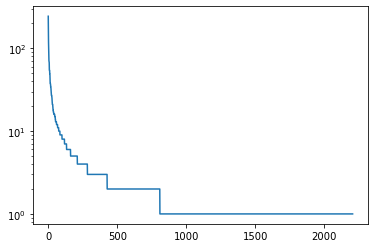

In [16]:
plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd,axis=1)))
plt.savefig("statistics.png")

(427, 257)

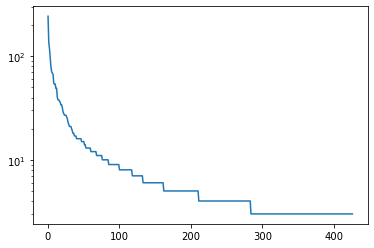

In [17]:
# remove words that are used once or twice
select = np.sum(Mwd,axis=1) > 2

Mwd = Mwd[select,:]
words = words[select]

# remove documents that do not contain words
select = (np.sum(Mwd,axis=0)>0)
Mwd = Mwd[:,select]
documents = documents[select]

# display final matrix size
display(Mwd.shape)

plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd,axis=1)))
plt.savefig("statistics.png")

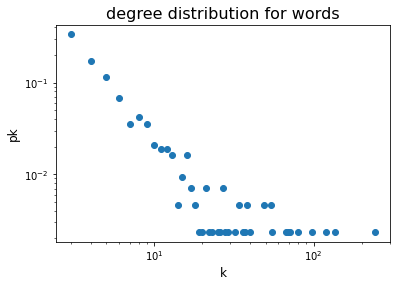

In [19]:
# degree distribution for words
dw = np.squeeze(np.asarray(Mwd.sum(axis=1))) # words degrees
k = np.unique(dw)
pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(k,pk,'o')
plt.title("degree distribution for words", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

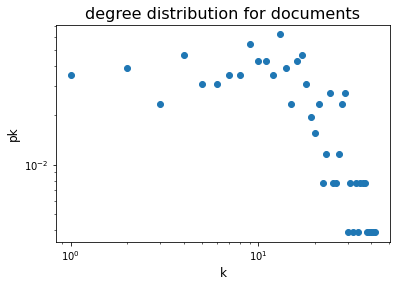

In [20]:
# degree distribution for documents
dd = np.squeeze(np.asarray(Mwd.sum(axis=0))) # documents degrees
k = np.unique(dd)
pk = np.histogram(dd,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(pk,'o')
plt.title("degree distribution for documents", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()